In [1]:
import sys
import time
import os
import subprocess
import math
import matplotlib.pyplot as plt
import numpy as np
import pylab as py
import random
import pandas as pd
from matplotlib import gridspec
from scipy import polyval, polyfit
from scipy.optimize import curve_fit
from datetime import datetime
import time
import corner
import emcee
from scipy.stats import linregress
from scipy import interpolate
from scipy import polyval, polyfit
from scipy import odr

In [2]:
####################################### Set Axes
def set_axes(ax, xlim=None, ylim=None, fontsize=16, twinx=True, twiny=True, minor=True, inout='in'):
        
        if not ylim is None:
            ax.set_ylim(ylim)
        else:
            ylim = ax.get_ylim() 
            
        if not xlim is None:    
            ax.set_xlim(xlim) 
        else:
            xlim = ax.get_xlim()
            
        ax.tick_params(which='major', length=6, width=1., direction=inout)
#         if minor:
        ax.tick_params(which='minor', length=3, color='#000033', width=1.0, direction=inout)  
        
        if twiny:
            y_ax = ax.twinx()
            y_ax.set_ylim(ylim)
            y_ax.set_yticklabels([])
            y_ax.minorticks_on()
            y_ax.tick_params(which='major', length=6, width=1., direction=inout)
            if minor:
                y_ax.tick_params(which='minor', length=3, color='#000033', width=1.0, direction=inout) 
        
        if twinx:
            x_ax = ax.twiny()
            x_ax.set_xlim(xlim)
            x_ax.set_xticklabels([])
            x_ax.minorticks_on()
            x_ax.tick_params(which='major', length=6, width=1.0, direction=inout)
            if minor:
                x_ax.tick_params(which='minor', length=3, color='#000033', width=1.0, direction=inout)     

        for tick in ax.xaxis.get_major_ticks():
                    tick.label.set_fontsize(fontsize) 
        for tick in ax.yaxis.get_major_ticks():
                    tick.label.set_fontsize(fontsize) 
        
        return x_ax, y_ax

In [3]:
df = pd.read_csv("edd_cf4_refined.csv", sep='|')


for col in df.columns:
    newcol = col.strip()
    df.rename(columns={col:newcol}, inplace=True)

df['D75'] = df.Vmod / 75.
df['logD75'] = np.log10(df.Vmod / 75.)
df['DM_75'] = 5*df.logD75 + 25 
df['Mg_75'] = df['g***'] - df.DM_75
df['Mr_75'] = df['r***'] - df.DM_75
df['Mi_75'] = df['i***'] - df.DM_75
df['Mz_75'] = df['z***'] - df.DM_75
df['M1_75'] = np.asarray([np.float64(x) for x in df['w1'].values]) - df.DM_75.values
df['M2_75'] = np.asarray([np.float64(x) for x in df['w2'].values]) - df.DM_75.values

df['gi'] = df['g***'] - df['i***']

#m21[i] = -2.5*np.log10(F_av_ESN[i])+17.40
#m21_e[i] = (2.5/np.log(10))*(eF_av_ESN[i]/F_av_ESN[i])
F21 = 10**(-0.4*(df.m21-17.40))   # HI 21cm Flux [Jy.km/s]
eF21 = (df.em21/(2.5/np.log(10)))*F21
df['F21'] = F21
df['eF21'] = eF21


df = df.set_index("PGC")
print(df.columns)
print(len(df))

df.head()

Index(['Name', 'Vhel', 'Vls', 'u', 'g', 'r', 'i', 'z', 'w1', 'w2',
       ...
       'DM_75', 'Mg_75', 'Mr_75', 'Mi_75', 'Mz_75', 'M1_75', 'M2_75', 'gi',
       'F21', 'eF21'],
      dtype='object', length=118)
10737


/home/ehsan/anaconda3/lib/python3.8/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/ehsan/anaconda3/lib/python3.8/site-packages/pandas/core/series.py:726: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


,Name,Vhel,Vls,u,g,r,i,z,w1,w2,...,DM_75,Mg_75,Mr_75,Mi_75,Mz_75,M1_75,M2_75,gi,F21,eF21
PGC,,,,,,,,,,,,,,,,,,,,,
2,UGC12889,5017.0,5309.5,0.00,0.00,0.00,0.00,0.00,11.86,12.49,...,34.024557,-34.024557,-34.024557,-34.024557,-34.024557,-22.164557,-21.534557,0.00,4.729334,0.805837
4,PGC000004,4458.0,4706.1,17.57,16.43,15.91,15.57,15.42,16.06,16.42,...,33.717026,-18.127026,-18.387026,-18.597026,-18.647026,-17.657026,-17.297026,0.47,1.926637,0.134862
12,PGC000012,6531.0,6667.6,0.00,0.00,0.00,0.00,0.00,13.60,14.20,...,34.620362,-34.620362,-34.620362,-34.620362,-34.620362,-21.020362,-20.420362,0.00,3.400948,0.579492
16,PGC000016,5713.0,5855.1,16.08,14.83,14.21,13.86,13.61,13.98,14.67,...,34.281429,-19.921429,-20.421429,-20.701429,-20.881429,-20.301429,-19.611429,0.78,1.194538,0.203539
55,UGC12898,4779.0,5052.2,16.82,16.08,15.71,15.50,15.40,16.18,16.60,...,33.894131,-18.364131,-18.574131,-18.674131,-18.724131,-17.714131,-17.294131,0.31,4.541507,0.317899


In [4]:
df_alfa = pd.read_csv("ALFALFA.csv", sep='|')
for col in df.columns:
    newcol = col.strip()
    df.rename(columns={col:newcol}, inplace=True)

df_alfa = df_alfa.set_index("PGC")
df_alfa = df_alfa[["F", "e_F"]]
df_alfa.head()

,F,e_F
PGC,,
4,1.96,0.07
6,1.13,0.09
10,2.47,0.06
20,2.30,0.11
28,2.49,0.11


In [5]:
df_adhi = pd.read_csv("ADHI.csv", sep='|')
for col in df.columns:
    newcol = col.strip()
    df.rename(columns={col:newcol}, inplace=True)
df_adhi = df_adhi.set_index("PGC")
df_adhi = df_adhi[["Flux"]]

df_adhi.head()

/home/ehsan/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3146: DtypeWarning: Columns (31,32) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


,Flux
PGC,
2,4.73
4,1.85
6,0.82
12,3.40
16,1.19


In [6]:
df = df.join(df_alfa, how='left')
df = df.join(df_adhi, how='left')

In [7]:
df['F21_av'] = df[["F", "Flux"]].mean(axis=1)

dg = df[["F21", "eF21", "F", "e_F", "Flux", "F21_av"]]
dg['F21_'] = dg.apply(lambda X: X.F21_av if ~np.isnan(X.F21_av) else X.F21, axis=1)
dg['F21_e'] = dg.apply(lambda X: X.e_F if ~np.isnan(X.F) else X.eF21, axis=1)

len(dg)

df["F21"] = dg.F21_
df["eF21"] = dg.F21_e

<ipython-input-7-b6dbfbfb12cb>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dg['F21_'] = dg.apply(lambda X: X.F21_av if ~np.isnan(X.F21_av) else X.F21, axis=1)
<ipython-input-7-b6dbfbfb12cb>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dg['F21_e'] = dg.apply(lambda X: X.e_F if ~np.isnan(X.F) else X.eF21, axis=1)


In [8]:
def linear(x, m, b):
    return m*x+b

def linear_m(x, m):
    return m*x

In [9]:
gamma = np.log10(0.5) + 0.4*5.91
df['logMs_W1'] = gamma - 0.4*df['M1_75']
df['Ms_W1'] = 10**df.logMs_W1

alfa = 0.3586
beta = 1.6479
df['logMs_i'] = beta + alfa*df.gi - 0.4*df['Mi_75']
df['Ms_i'] = 10**df.logMs_i

df['Mass_HI'] = 2.356E5 * df.F21 * (df.D75**2)

2.5713702552808697 -5.578310027188077


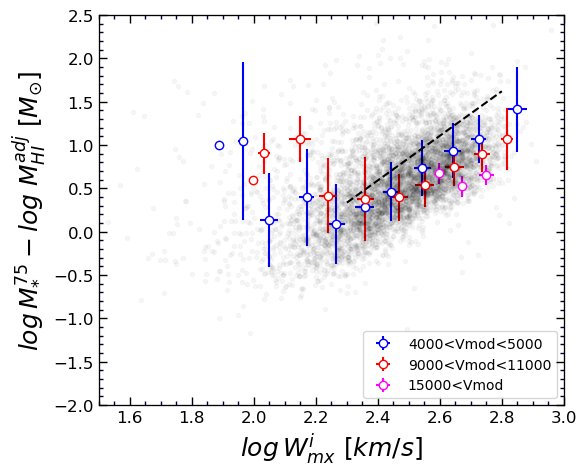

In [10]:
fig = py.figure(figsize=(5,5), dpi=100)    
fig.subplots_adjust(wspace=0, top=0.9, bottom=0.12, left=0.05, right=0.98)
ax = fig.add_subplot(111)

dff = df[(df.Qw>2)&(df.elgWi>0)&(df.lgWmxi>0)]
X0 = dff.lgWmxi.values
Y0 = dff.logMs_W1.values-np.log10(dff.Mass_HI.values)
Vmod = dff.Vmod.values
# Y0 = Y0 - (mc*Vmod+bc)

ax.plot(X0, Y0, 'k.', alpha=0.03)

label='4000<Vmod<5000'
ind, = np.where((Vmod>4000)&(Vmod<5000))
X = X0[ind]
Y = Y0[ind]
lab = True
for i in np.arange(1.7,2.9,0.1):
    xp = []
    yp = []
    for ii in range(len(X)):
        xi = X[ii]
        if xi>=i and xi<i+0.1:
            xp.append(xi)
            yp.append(Y[ii])
    if len(xp)>0:
        if lab:
            labe = label
            lab = False
        else:
            labe=None        
        ax.errorbar(np.median(xp), np.median(yp), yerr=np.std(yp), xerr=np.std(xp), fmt='o', 
                    color='blue', ms=6, mfc='white', label=labe)            
        

label='9000<Vmod<11000'
lab = True
ind, = np.where((Vmod>9000)&(Vmod<11000))
X = X0[ind]
Y = Y0[ind]
for i in np.arange(1.7,2.9,0.1):
    xp = []
    yp = []
    for ii in range(len(X)):
        xi = X[ii]
        if xi>=i and xi<i+0.1:
            xp.append(xi)
            yp.append(Y[ii])
    if len(xp)>0:
        if lab:
            labe = label
            lab = False
        else:
            labe=None   
        ax.errorbar(np.median(xp), np.median(yp), yerr=np.std(yp), xerr=np.std(xp), fmt='o', 
                    color='red', ms=6, mfc='white', label=labe)            
        
        
label='15000<Vmod'
lab = True
ind, = np.where((Vmod>9000)&(Vmod<11000))
X = X0[ind]
Y = Y0[ind]        
ind, = np.where((Vmod>15000))
X = X0[ind]
Y = Y0[ind]
for i in np.arange(1.7,2.9,0.1):
    xp = []
    yp = []
    for ii in range(len(X)):
        xi = X[ii]
        if xi>=i and xi<i+0.1:
            xp.append(xi)
            yp.append(Y[ii])
    if len(xp)>0:
        if lab:
            labe = label
            lab = False
        else:
            labe=None   
        ax.errorbar(np.median(xp), np.median(yp), yerr=np.std(yp), xerr=np.std(xp), fmt='o', 
                    color='magenta', ms=6, mfc='white', label=labe)             
        
ax.set_xlabel(r'$log \/ W_{mx}^i \/\/[km/s]$', fontsize=18) 
ax.set_ylabel(r'$log \/ M_{*}^{75}-log \/\/ M_{HI}^{adj} \/\/ [M_{\odot}]$', fontsize=18)
set_axes(ax, (1.5,3), (-2,2.5), fontsize=12)

ax.legend()


x = np.linspace(2.3, 2.8, 100)
ind, = np.where((X0>2.3)&(dff.Vmod>0)&(dff.Vmod<2000)&(X0<2.8))
fit, cov = curve_fit(linear, X0[ind], Y0[ind])
m, b = fit[0], fit[1]
ax.plot(x, m*x + b, '--', color='k')

print(m,b)
# m = 2.3548648770909377 
# b = -5.000227567400469

-4.521615511740707e-05


<ipython-input-11-15eac338184c>:40: RuntimeWarning: invalid value encountered in greater
  ff = np.polyfit(X[(X<5000)&(Y>-3)], Y[(X<5000)&(Y>-3)], 2)


(<AxesSubplot:label='3ce5cb01-97f7-42d5-ace4-e8e77fbc18c1'>,
 <AxesSubplot:label='8c102a31-c663-4daf-b45d-2cc7913d2bf5'>)

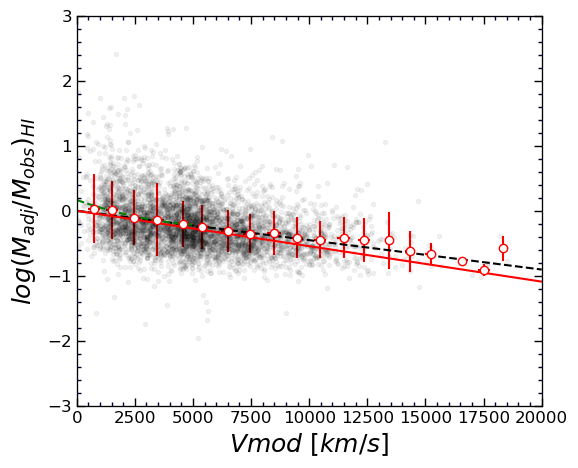

In [11]:
fig = py.figure(figsize=(5,5), dpi=100)    
fig.subplots_adjust(wspace=0, top=0.9, bottom=0.12, left=0.05, right=0.98)
ax = fig.add_subplot(111)


Y = Y0-(m*X0+b)
X = Vmod

X = X[X0>2.2]
Y = Y[X0>2.2]
ax.plot(X, Y, 'k.', alpha=0.05)

for i in np.arange(0, 20000, 1000):
    xp = []
    yp = []
    for ii in range(len(X)):
        xi = X[ii]
        if xi>=i and xi<i+1000:
            xp.append(xi)
            yp.append(Y[ii])
    if len(xp)>0:
        if lab:
            labe = label
            lab = False
        else:
            labe=None   
        ax.errorbar(np.median(xp), np.mean(yp), yerr=np.std(yp), xerr=np.std(xp), fmt='o', 
                    color='red', ms=6, mfc='white', label=labe) 

x = np.linspace(0,20000,1000)
fit, cov = curve_fit(linear_m, X[(X>4000)&(X<10000)], Y[(X>4000)&(X<10000)])
mc = fit[0] #; bc=fit[1]
ax.plot(x, mc*x, '--', color='k')
print(mc)

mc = -5.451168100093722e-05
ax.plot(x, mc*x, '-', color='r')


ff = np.polyfit(X[(X<5000)&(Y>-3)], Y[(X<5000)&(Y>-3)], 2)
x = np.linspace(0,5000,1000)
y = x*0.
n = len(ff)
for i in range(n):
    y += ff[i]*x**(n-i-1)

    
ax.plot(x, y, '--', color='g')

ax.set_ylabel(r'$log (M_{adj}/M_{obs})_{HI}$', fontsize=18) 
ax.set_xlabel(r'$Vmod \/\/ [km/s] $', fontsize=18)
set_axes(ax, (0, 20000), (-3,3), fontsize=12)

In [12]:
def HI_corrector(fit, mc, bc, Vmod, Vlim=4000, simple=True):
    
#     fit = fit*0
#     mc = mc * 0
#     bc = bc * 0
    
    try:
        y1 = Vmod*0.
        n = len(fit)
        for i in range(n):
            y1 += fit[i]*Vmod**(n-i-1)    

        y2 = mc*Vmod+bc

        y = np.asarray([y1[i] if Vmod[i]<=Vlim else y2[i] for i in range(len(Vmod))])
        if simple:
            return y2
        return y
    except:
        if simple:
            return mc*Vmod+bc
        if Vmod<Vlim:
            y = 0.
            n = len(fit)
            for i in range(n):
                y += fit[i]*Vmod**(n-i-1)  
            return y
        else:
            return mc*Vmod+bc
    
    

/home/ehsan/anaconda3/lib/python3.8/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
<ipython-input-13-5fe5228567ec>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dff['delta'] = 0.
<ipython-input-13-5fe5228567ec>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dff['delta'] = m0*(dff.lgWmxi-2.5)+b0 - dff.logMb
<ipython-input-13-5fe5228567ec>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy 

iter:  0
iter:  1
3.330123515596931 10.324724577080563


Text(2.4539999999999997, 7.5, '$ZP = $10.32$\\pm$0.00')

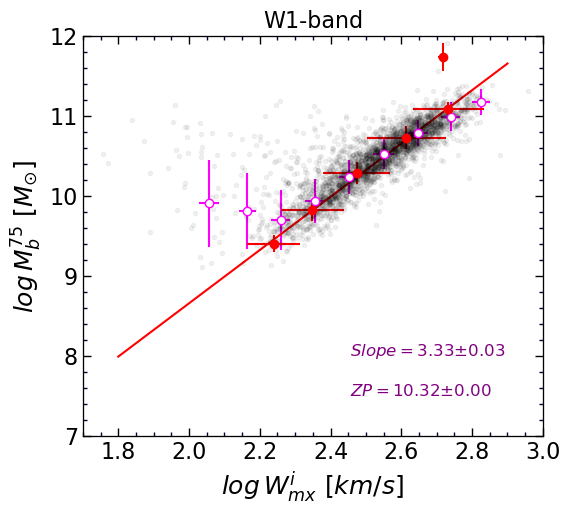

In [13]:
df['Mb'] = df.Ms_W1 + 1.33*(10**(np.log10(df.Mass_HI)+HI_corrector(ff, mc, 0, df.Vmod.values)))
df['logMb'] = np.log10(df.Mb.values)

dff = df[(df.Qw>2)&(df.elgWi>0)&(df.lgWmxi>0)&(df.Vmod>4000)]
std = 1.E10
dff['delta'] = 0.

for jj in range(2):
    
    dff = dff[np.abs(dff.delta)<3.5*std]

    logW = dff.lgWmxi.values
    logWe = dff.elgWi.values
    logMass = dff.logMb.values
    Vmod = dff.Vmod.values

    ln10 = np.log(10)
    dMs = 0.4*0.05*ln10
    dM21 = 2.356E5 * dff.eF21 * (dff.D75**2)
    dMb = np.sqrt(dMs**2+(1.33**2)*dM21**2)
    dlogMb = dMb/dff.Mb/ln10


    fit, cov = curve_fit(linear, logMass, logW-2.5, sigma=np.sqrt(logWe**2+(0.01)**2))
    m, b = fit[0], fit[1]
    me = np.sqrt(cov[0,0])
    be = np.sqrt(cov[1,1])
    mbe = cov[1,0]    
    m0 = 1./m
    b0 = -b/m
    dm0 = np.abs(me/m**2)
    db0 = np.sqrt((b0**2 )*(be**2/b**2+me**2/m**2-2*mbe/m/b))
    

    dff = df[(df.Qw>2)&(df.elgWi>0)&(df.lgWmxi>0)&(df.Vmod>4000)]
    dff['delta'] = m0*(dff.lgWmxi-2.5)+b0 - dff.logMb
    std = dff['delta'].std()
    
    print("iter: ", jj)
    

logW = dff.lgWmxi.values
logMass = dff.logMb.values
print(m0,b0)

fig = py.figure(figsize=(5, 5), dpi=100)    
fig.subplots_adjust(wspace=0, top=0.92, bottom=0.12, left=0.06, right=0.98)
gs = gridspec.GridSpec(1,1) ; p=0
ax = plt.subplot(gs[p]) ; p+=1


w = np.linspace(1.8,2.9,100)
ax.plot(w, m0*(w-2.5) + b0, 'r-')
ax.plot(logW, logMass, 'k.', alpha=0.05)    
    
    
    
ax.set_xlabel(r'$log \/ W_{mx}^i \/\/[km/s]$', fontsize=18) 
ax.set_ylabel(r'$log \/ M_b^{75} \/\/ [M_{\odot}]$', fontsize=18)
set_axes(ax, (1.7,3), (7,12))

ax.set_title("W1-band", fontsize=16)



X = logW
Y = logMass
for i in np.arange(2,2.9,0.1):
    xp = []
    yp = []
    for ii in range(len(X)):
        xi = X[ii]
        if xi>=i and xi<i+0.1:
            xp.append(xi)
            yp.append(Y[ii])
    if len(xp)>0:
        ax.errorbar(np.mean(xp), np.median(yp), yerr=np.std(yp), xerr=np.std(xp), fmt='o', 
                    color='magenta', ms=6, mfc='white')   
        
for i in np.arange(8,12,0.5):
    xp = []
    yp = []
    for ii in range(len(Y)):
        xi = Y[ii]
        if xi>=i and xi<i+0.5:
            xp.append(xi)
            yp.append(X[ii])
    if len(xp)>0:
        ax.errorbar(np.median(yp), np.median(xp), yerr=np.std(xp), xerr=np.std(yp), fmt='o', 
                    color='r', ms=6)  
        
        
Ylm = ax.get_ylim() ; Xlm = ax.get_xlim()
x0 = 0.42*Xlm[0]+0.58*Xlm[1]
y0 = 0.80*Ylm[0]+0.2*Ylm[1]
ax.text(x0,y0, r"$Slope = $"+"%.2f" % m0+'$\pm$'+"%.2f" % dm0, fontsize=12, color='purple')
y0 = 0.90*Ylm[0]+0.10*Ylm[1]
ax.text(x0,y0, r"$ZP = $"+"%.2f" % b0+'$\pm$'+"%.2f" % db0, fontsize=12, color='purple')



In [14]:
def getDM(mag, Wlog, F21, m0, b0, D, Vmod):
    
    Mb = 10**(m0*(Wlog-2.5)+b0)
    
    M21 = 2.356E5 * F21 * (D**2)
    M21 = 10**(np.log10(M21) + HI_corrector(ff, mc, 0, Vmod))
    
    Mag = -2.5*(np.log10(Mb - 1.33*M21) - gamma)
    
    DM = mag - Mag
    
    D = 10**((DM-25)/5)
    
    return D


def interpol(X, Y):
    
    X0 = X[~np.isnan(Y)]
    Y0 = Y[~np.isnan(Y)]
      
    N = len(X0)
    
    for i in range(N-1):
        
        if Y0[i]<0 and Y0[i+1]>0:
            break

    return -Y0[i]*(X0[i+1]-X0[i])/(Y0[i+1]-Y0[i])+X0[i]

In [15]:
dff = df[(df.Qw>0)&(df.elgWi>0)&(df.lgWmxi>0)]
mag = dff["w1***"].values
Wlog = dff.lgWmxi.values
F21 = dff.F21.values
D75 = dff.D75.values
gi = dff.gi.values
Vmod = dff.Vmod.values
PGC = dff.index.values

N = len(dff)
M1_fid = np.zeros(N)
print(N)
pp=0

for j in range(N):
    mag_ = mag[j]

    D = np.arange(500)
    delta = D*0.

    for i in range(500):
        delta[i] =  D[i] - getDM(mag[j], Wlog[j], F21[j], m0, b0, D[i], Vmod[j])


    D = D[~np.isnan(delta)]
    delta = delta[~np.isnan(delta)]

    try:
#         D_left = np.max(D[delta<0])
#         D_right = np.min(D[delta>0])
#         D_root = 0.5*(D_left+D_right)
        D_root = interpol(D, delta)
        
        DM_fid = 5*np.log10(D_root)+25
        M1_fid[j] = mag_ -  DM_fid
    except:
        D_root = np.max(D[delta<0])
        DM_fid = 5*np.log10(D_root)+25
        M1_fid[j] = mag_ -  DM_fid    
        pp+=1
    if j%1000==0:
        print(j)
        
    if PGC[j]==1781:
        print(j, mag_, DM_fid, D_root)

print("Number of concerning distances:", pp)

5478
0


<ipython-input-14-9597b3a5c471>:6: RuntimeWarning: divide by zero encountered in log10
  M21 = 10**(np.log10(M21) + HI_corrector(ff, mc, 0, Vmod))
<ipython-input-14-9597b3a5c471>:8: RuntimeWarning: invalid value encountered in log10
  Mag = -2.5*(np.log10(Mb - 1.33*M21) - gamma)


180 15.65 29.52701916979397 8.042736381251773
1000
2000
3000
4000
5000
Number of concerning distances: 0


8.042736381251773


<ipython-input-14-9597b3a5c471>:6: RuntimeWarning: divide by zero encountered in log10
  M21 = 10**(np.log10(M21) + HI_corrector(ff, mc, 0, Vmod))
<ipython-input-14-9597b3a5c471>:8: RuntimeWarning: invalid value encountered in log10
  Mag = -2.5*(np.log10(Mb - 1.33*M21) - gamma)


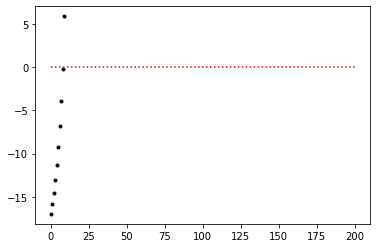

In [16]:
j = 180
D = np.arange(500)
delta = D*0.
for i in range(500):
        delta[i] =  D[i] - getDM(mag[j], Wlog[j], F21[j], m0, b0, D[i], Vmod[j])

plt.plot(D, delta, 'k.') 
plt.plot([0,200], [0,0], "r:")

print(interpol(D, delta))


<ipython-input-17-ca37f5da1183>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dff['dDM'] = M1_fid - dff.M1_75.values


Text(0.5, 1.0, 'BTFR: W1-band')

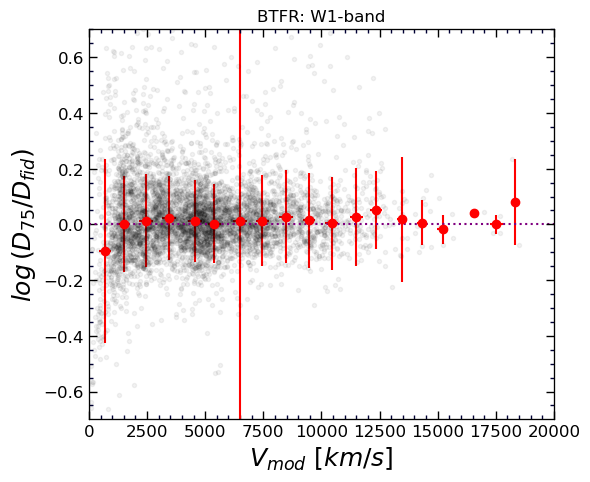

In [17]:
dff['dDM'] = M1_fid - dff.M1_75.values

fig = py.figure(figsize=(5,5), dpi=100)    
fig.subplots_adjust(wspace=0, top=0.9, bottom=0.12, left=0.05, right=0.98)
ax = fig.add_subplot(111)


X = dff.Vmod.values
Y = dff.dDM.values/5


ax.plot(X, Y, 'k.', alpha=0.05)

for i in np.arange(0,20000,1000):
    xp = []
    yp = []
    for ii in range(len(X)):
        xi = X[ii]
        if xi>=i and xi<i+1000:
            xp.append(xi)
            yp.append(Y[ii])
    if len(xp)>0:
        ax.errorbar(np.median(xp), np.median(yp), yerr=np.std(yp), xerr=np.std(xp), fmt='o', 
                    color='r', ms=6)   
#         print(np.mean(xp), np.median(yp))

        
ax.set_xlabel(r'$V_{mod} \/\/[km/s]$', fontsize=18) 
# ax.set_ylabel(r'$DM_{75} - DM_{fid}$', fontsize=18)
ax.set_ylabel(r'$log \/ (D_{75}/D_{fid})$', fontsize=18)

ax.plot([0,20000], [0,0], ':', color='purple')

set_axes(ax, (0,20000), (-0.7,0.7), fontsize=12)

ax.set_title("BTFR: W1-band")


Text(0.5, 1.0, 'BTFR: W1-band')

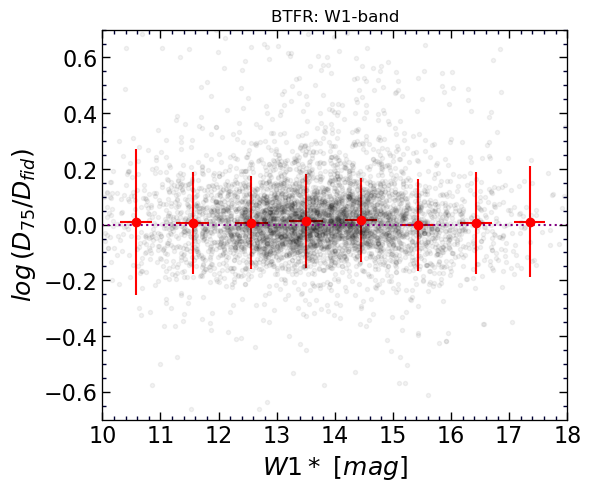

In [18]:
fig = py.figure(figsize=(5,5), dpi=100)    
fig.subplots_adjust(wspace=0, top=0.9, bottom=0.12, left=0.05, right=0.98)
ax = fig.add_subplot(111)


X = dff['w1***'].values
Y = dff.dDM.values/5.
V = dff.Vmod.values


ax.plot(X, Y, 'k.', alpha=0.05)

for i in np.arange(10,18,1):
    xp = []
    yp = []
    for ii in range(len(X)):
        xi = X[ii]
        if xi>=i and xi<i+1 and ~np.isnan(xi) and ~np.isnan(Y[ii]):
            xp.append(xi)
            yp.append(Y[ii])
    if len(xp)>0:
        ax.errorbar(np.mean(xp), np.median(yp), yerr=np.std(yp), xerr=np.std(xp), fmt='o', 
                    color='r', ms=6)   
#         print(np.mean(xp), np.median(yp))

        
ax.set_xlabel(r'$W1* \/\/[mag]$', fontsize=18) 
# ax.set_ylabel(r'$DM_{75} - DM_{fid}$', fontsize=18)
ax.set_ylabel(r'$log \/ (D_{75}/D_{fid})$', fontsize=18)


ax.plot([10,18], [0,0], ':', color='purple')

set_axes(ax, (10,18), (-0.7,0.7))

ax.set_title("BTFR: W1-band")

In [20]:
dff['DM1_fid'] = dff["w1***"] - M1_fid

dff[['Vmod', 'DM_75', 'DM1_fid', 'F21', 'eF21', 'lgWmxi', 'elgWi', 'Qw', 'w1***']].to_csv("BTFR_W1_distances.csv")

<ipython-input-20-ee581cd79e57>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dff['DM1_fid'] = dff["w1***"] - M1_fid
